In [1]:
import spacy
import pandas as pd

# Pastikan Anda sudah menginstal model en_ner_bc5cdr_md:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_ner_bc5cdr_md-0.5.3.tar.gz
nlp = spacy.load("en_ner_bc5cdr_md")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.5.3-py3-none-any.whl size=119790307 sha256=b3ad8c1f68c9f86b09dc0017ea17bb0f3f3c076ba612b88f9d1984c8b5079211
  Stored in directory: /root/.cache/pip/wheels/14/f5/28/d5bb4d966a84523c9135ec2113fb756fcc3098929f841334c1
Successfully built en_ner_bc5cdr_md
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
  Attempting unin

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.3) was trained with spaCy v3.6.1 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  self.meta.update(data)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
df = pd.read_csv("/content/drive/Shareddrives/Riset 2023/DataKratomGraph.csv")
df.head()

,abstract
0,"Mitragyna speciosa Korth also known as kratom,..."
1,"Mitragynine, an analgesic alkaloid from the pl..."
2,Kratom (Mitragyna speciosa) is a Southeast Asi...
3,BACKGROUND: Consumption of kratom (Mitragyna s...
4,Introduction: Chronic neuropathic pain is as a...


In [8]:
number_of_samples = 395
sample_transcription = df['abstract'].iloc[:number_of_samples]
print(sample_transcription[:1000]) # prints just the first 1000 characters

0      Mitragyna speciosa Korth also known as kratom,...
1      Mitragynine, an analgesic alkaloid from the pl...
2      Kratom (Mitragyna speciosa) is a Southeast Asi...
3      BACKGROUND: Consumption of kratom (Mitragyna s...
4      Introduction: Chronic neuropathic pain is as a...
                             ...                        
390    We examined the use of Kratom (Mitragyna sp.),...
391    In Thailand, there are four Mitragyna species;...
392    Administration of the aqueous extract of Mitra...
393    Kratom (Mitragyna speciosa) is a tropical plan...
394    The kratom story in Malaysia is a bit intricat...
Name: abstract, Length: 395, dtype: object


In [9]:
# Contoh input berupa daftar teks
#sample_transcription = [
#    "Aspirin is known to cause gastric bleeding.",
#    "Paracetamol can lead to liver damage in high doses.",
#    "Ibuprofen is associated with kidney problems."
#]

def extract_entities_and_relations(transcriptions):
    """
    Ekstraksi entitas Chemical dan Disease serta relasi antara keduanya dari daftar teks.

    Args:
    - transcriptions (list of str): Daftar teks transkripsi.

    Returns:
    - entities (list of dict): Daftar entitas Chemical dan Disease.
    - relations (list of tuple): Daftar relasi (Chemical, Disease, Verb) yang terdeteksi.
    """
    entities = []
    relations = []

    for text in transcriptions:
        doc = nlp(text)

        # Debugging untuk melihat entitas yang terdeteksi
        detected_ents = [(ent.text, ent.label_) for ent in doc.ents]
        print(f"Detected entities in text: '{text}': {detected_ents}")

        # Mengumpulkan entitas Chemical dan Disease
        text_chemicals = [ent.text for ent in doc.ents if ent.label_ == "CHEMICAL"]
        text_diseases = [ent.text for ent in doc.ents if ent.label_ == "DISEASE"]

        for chemical in text_chemicals:
            entities.append({"type": "CHEMICAL", "text": chemical})
        for disease in text_diseases:
            entities.append({"type": "DISEASE", "text": disease})

        # Menemukan relasi antara Chemical dan Disease dengan konteks kata kerja
        for chemical in text_chemicals:
            for disease in text_diseases:
                for token in doc:
                    if token.pos_ == "VERB" or token.dep_ == "ROOT":
                        if chemical in token.sent.text and disease in token.sent.text:
                            relations.append((chemical, disease, token.text))

    return entities, relations

# Panggil fungsi untuk mengekstraksi entitas dan relasi
entities, relations = extract_entities_and_relations(sample_transcription)

# Buat DataFrame untuk entitas
entities_df = pd.DataFrame(entities)

# Buat DataFrame untuk relasi
if relations:
    relations_df = pd.DataFrame(relations, columns=["Chemical", "Disease", "Verb"])
else:
    relations_df = pd.DataFrame(columns=["Chemical", "Disease", "Verb"])

# Tampilkan hasil
print("Entities DataFrame:")
print(entities_df)

print("\nRelations DataFrame:")
print(relations_df)


Streaming output truncated to the last 5000 lines.
Detected entities in text: 'Kratom (Mitragyna speciosa) is a popular plant-based extract that 
has dose-dependent stimulatory and sedative effects. It has been used for 
self-treatment of opioid withdrawal and can result in seizures, hepatotoxicity, 
and infectious complications from bacterial contamination. Reports of morbidity 
and mortality associated with Kratom may be confounded by coingestants. We 
report a case of severe rhabdomyolysis and pressure necrosis leading to 
fasciotomy in a patient who was using Kratom.
CASE REPORT: A 31-year-old male with substance use presented to the emergency 
department after loss of consciousness for 6 hours after smoking Kratom. He was 
found to have rhabdomyolysis, acute renal and hepatic injury, and electrolyte 
disturbances. No ethanol was detected, and urine drug screen was negative. Over 
the next 3 hours, the patient developed signs of compartment syndrome and he was 
transferred to the o

In [15]:
def save_relations_to_csv(relations_df, filename):
    """
    Menyimpan DataFrame relasi ke file CSV.

    Args:
    - relations_df (DataFrame): DataFrame dengan kolom ["Chemical", "Disease", "Verb"].
    - filename (str): Nama file untuk menyimpan CSV (contoh: "relations.csv").

    Returns:
    - None
    """
    try:
        # Simpan DataFrame ke file CSV
        relations_df.to_csv(filename, index=False)
        print(f"Relations saved successfully to {filename}.")
    except Exception as e:
        print(f"Error saving relations to CSV: {e}")

# Panggil fungsi untuk menyimpan DataFrame ke CSV
save_relations_to_csv(relations_df, "/content/drive/MyDrive/Text Classification 2023/relations.csv")


Relations saved successfully to /content/drive/MyDrive/Text Classification 2023/relations.csv.


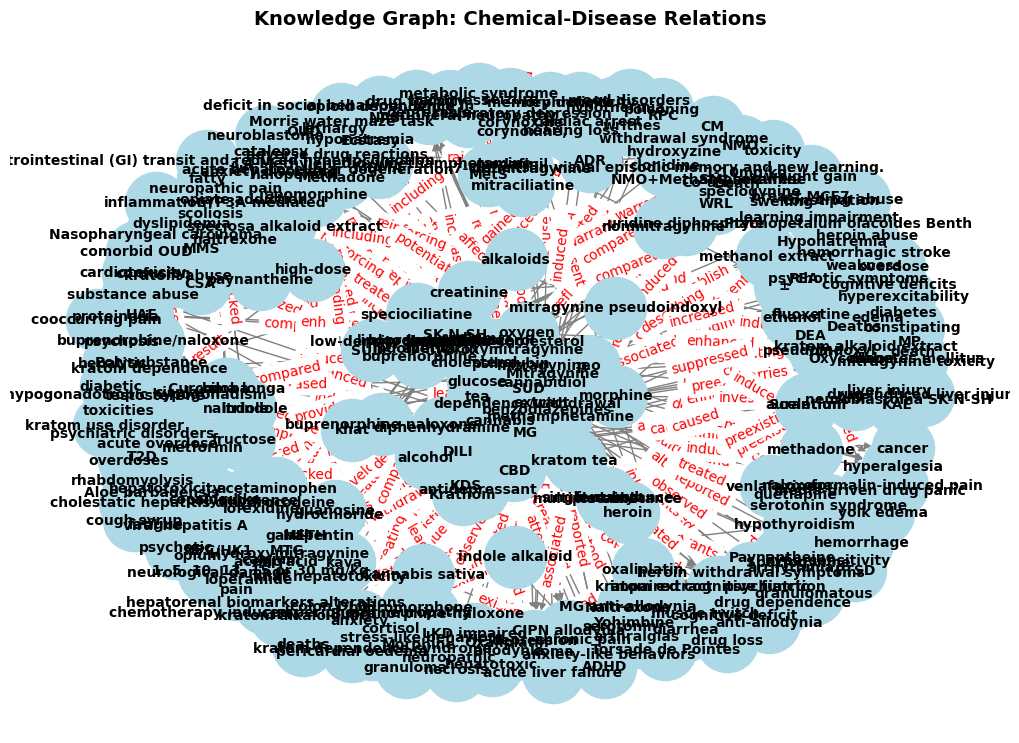

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

def create_knowledge_graph(relations_df):
    """
    Membuat dan memvisualisasikan knowledge graph dari Relations DataFrame.

    Args:
    - relations_df (DataFrame): DataFrame dengan kolom ["Chemical", "Disease", "Verb"].

    Returns:
    - None (Knowledge graph divisualisasikan menggunakan matplotlib).
    """
    # Inisialisasi graph
    G = nx.DiGraph()

    # Tambahkan node dan edge ke graph
    for _, row in relations_df.iterrows():
        chemical = row["Chemical"]
        disease = row["Disease"]
        verb = row["Verb"]

        # Tambahkan edge dengan verb sebagai label
        G.add_edge(chemical, disease, label=verb)

    # Posisi node menggunakan layout spring
    pos = nx.spring_layout(G)

    # Gambar node dan edge
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold")

    # Tambahkan label untuk edge
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)

    # Tampilkan graph
    plt.title("Knowledge Graph: Chemical-Disease Relations", fontsize=14, fontweight="bold")
    plt.show()


# Panggil fungsi untuk membuat knowledge graph
create_knowledge_graph(relations_df)


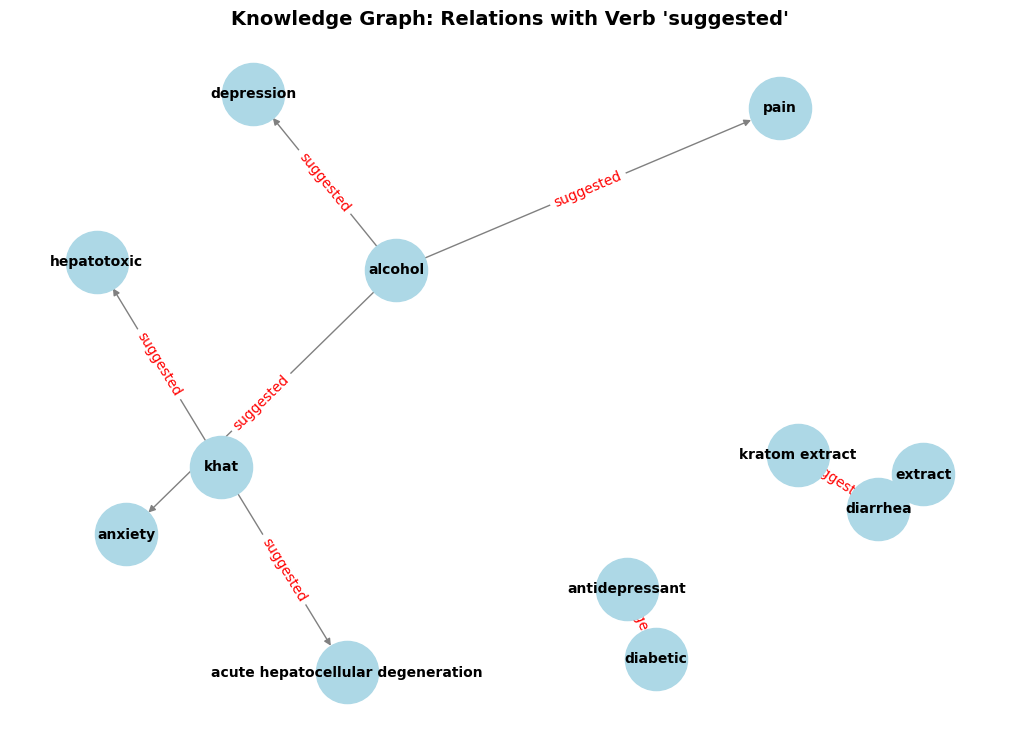

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

def create_filtered_knowledge_graph(relations_df, target_verb):
    """
    Membuat dan memvisualisasikan knowledge graph yang hanya menyertakan relasi dengan kata kerja tertentu.

    Args:
    - relations_df (DataFrame): DataFrame dengan kolom ["Chemical", "Disease", "Verb"].
    - target_verb (str): Kata kerja yang menjadi filter untuk relasi.

    Returns:
    - None (Knowledge graph divisualisasikan menggunakan matplotlib).
    """
    # Filter DataFrame untuk hanya menyertakan relasi dengan kata kerja target
    filtered_df = relations_df[relations_df["Verb"] == target_verb]

    # Inisialisasi graph
    G = nx.DiGraph()

    # Tambahkan node dan edge ke graph
    for _, row in filtered_df.iterrows():
        chemical = row["Chemical"]
        disease = row["Disease"]
        verb = row["Verb"]

        # Tambahkan edge dengan verb sebagai label
        G.add_edge(chemical, disease, label=verb)

    # Jika tidak ada relasi yang cocok, beri pesan dan hentikan
    if filtered_df.empty:
        print(f"No relations found with verb '{target_verb}'.")
        return

    # Posisi node menggunakan layout spring
    pos = nx.spring_layout(G)

    # Gambar node dan edge
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold")

    # Tambahkan label untuk edge
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)

    # Tampilkan graph
    plt.title(f"Knowledge Graph: Relations with Verb '{target_verb}'", fontsize=14, fontweight="bold")
    plt.show()

# Panggil fungsi untuk membuat knowledge graph dengan filter "exhibited"
create_filtered_knowledge_graph(relations_df, target_verb="suggested")


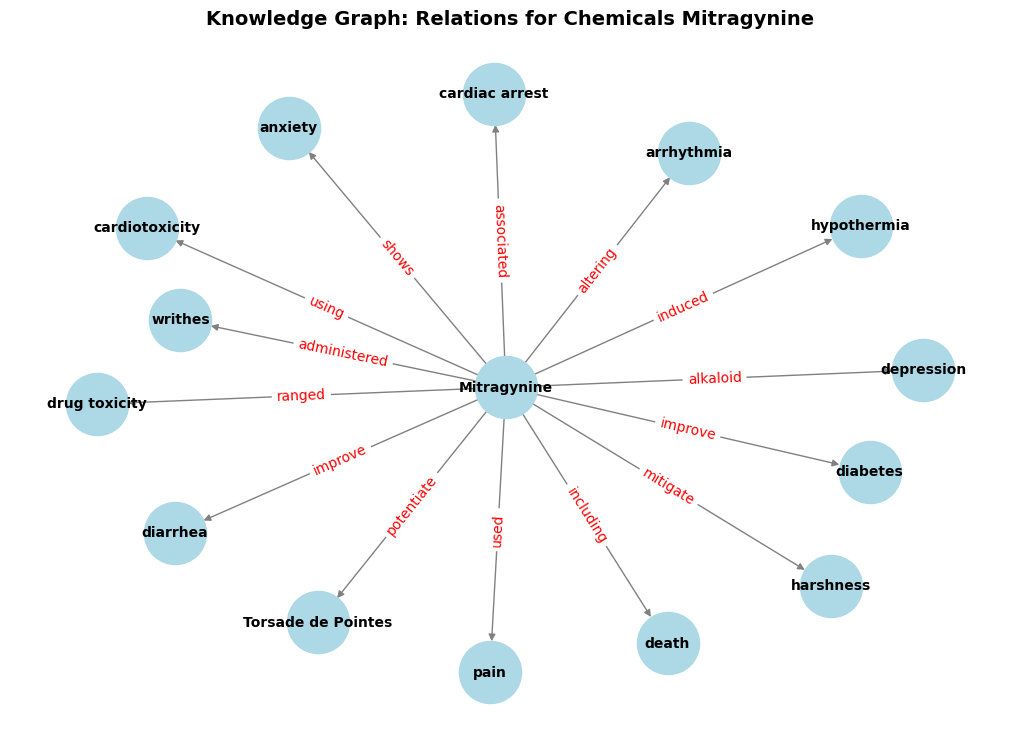

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

def create_filtered_knowledge_graph_by_chemical(relations_df, target_chemicals):
    """
    Membuat dan memvisualisasikan knowledge graph yang hanya menyertakan relasi dengan chemicals tertentu.

    Args:
    - relations_df (DataFrame): DataFrame dengan kolom ["Chemical", "Disease", "Verb"].
    - target_chemicals (list): Daftar chemicals yang menjadi filter untuk relasi.

    Returns:
    - None (Knowledge graph divisualisasikan menggunakan matplotlib).
    """
    # Filter DataFrame untuk hanya menyertakan relasi yang melibatkan chemicals yang ditargetkan
    filtered_df = relations_df[relations_df["Chemical"].isin(target_chemicals)]

    # Inisialisasi graph
    G = nx.DiGraph()

    # Tambahkan node dan edge ke graph
    for _, row in filtered_df.iterrows():
        chemical = row["Chemical"]
        disease = row["Disease"]
        verb = row["Verb"]

        # Tambahkan edge dengan verb sebagai label
        G.add_edge(chemical, disease, label=verb)

    # Jika tidak ada relasi yang cocok, beri pesan dan hentikan
    if filtered_df.empty:
        print(f"No relations found for chemicals: {target_chemicals}.")
        return

    # Posisi node menggunakan layout spring
    pos = nx.spring_layout(G)

    # Gambar node dan edge
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold")

    # Tambahkan label untuk edge
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)

    # Tampilkan graph
    plt.title(f"Knowledge Graph: Relations for Chemicals {', '.join(target_chemicals)}", fontsize=14, fontweight="bold")
    plt.show()


# Panggil fungsi untuk membuat knowledge graph untuk Mitragynine dan Kratom
create_filtered_knowledge_graph_by_chemical(relations_df, target_chemicals=["Mitragynine"])
